In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy.stats import norm

## Load results of MC simulation

In [2]:
with open('results_dict.pkl', 'rb') as pickle_file:
    results_dict_ = pickle.load(pickle_file)

In [3]:
results_dict = {}

for N, results in results_dict_.items():
    ate_estimates, sigma_estimates, CIs = results
    results_dict[N] = [ate_estimates[:, [0, 1, 2, 5]], sigma_estimates, CIs]

## Assess convergence rates and asymptotic properties

In [4]:
theta_0 = 1.0   # true ATE
sample_sizes = list(results_dict.keys())
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange']
names = ['Infeasible', 'No cross-fitting', '2-fold', '5-fold']

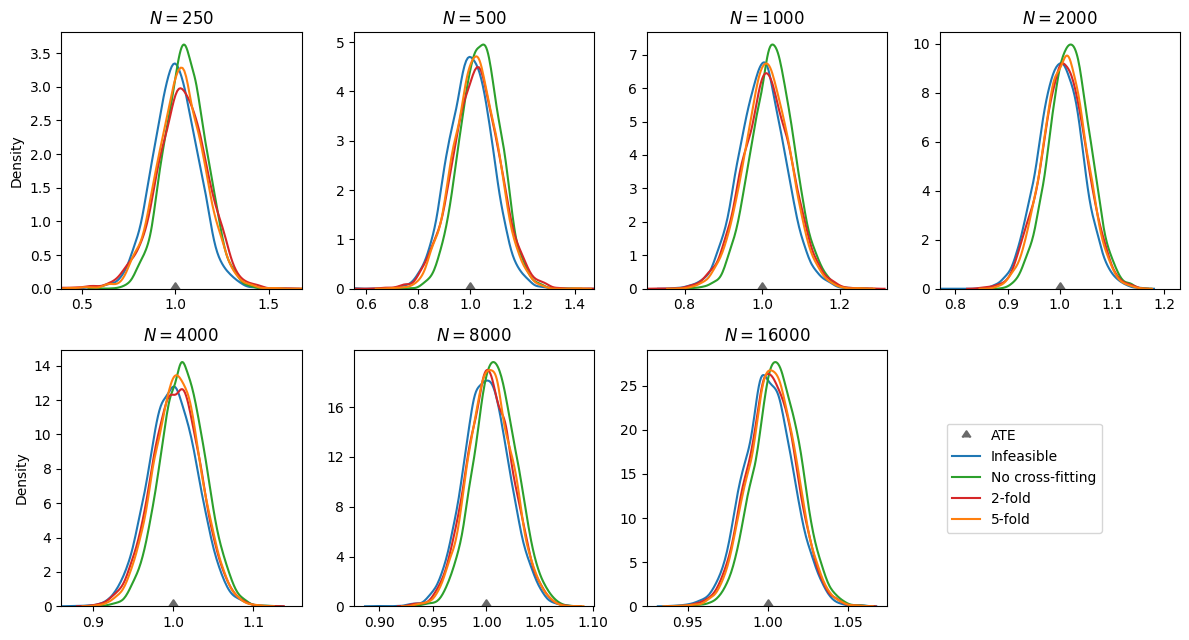

In [5]:
# Visual comparison of estimators
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, (N, results) in enumerate(results_dict.items()):
    ax = axes.flat[i]
    ax.scatter(theta_0, 0, marker=10, color='dimgrey', label='ATE')
    ate_estimates = results[0]
    for k in range(4):
        sns.kdeplot(ate_estimates[:,k], ax=ax, color=colors[k], label=names[k])
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('')
    if i==0:
        ax.set_xlim(left=0.39, right=1.675)
    elif i==1:
        ax.set_xlim(left=0.555, right=1.475)
    elif i==2:
        ax.set_xlim(left=0.703, right=1.322)
    elif i==3:
        ax.set_xlim(left=0.77, right=1.23)
    elif i==4:
        ax.set_xlim(left=0.86, right=1.16)
    elif i==5:
        ax.set_yticks([0, 4, 8, 12, 16])
    if i==6: 
        handles, labels = ax.get_legend_handles_labels()

axes.flat[-1].legend(handles, labels, loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_2/Visual_comparison.{fmt}', dpi=300, bbox_inches='tight')

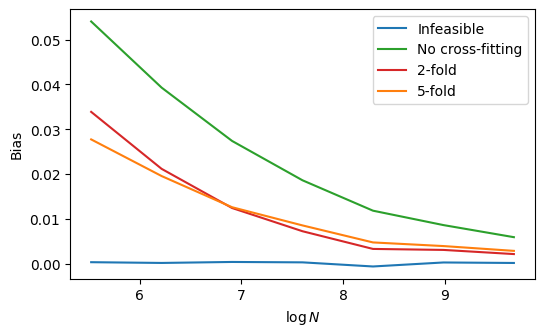

In [6]:
# Bias
bias = np.empty((len(sample_sizes), 4))

for i, (N, results) in enumerate(results_dict.items()):
    ate_estimates = results[0]
    bias[i] = np.mean(ate_estimates-theta_0, axis=0)

plt.figure(figsize=(6, 3.5))
for k in range(4):
    plt.plot(np.log(sample_sizes), bias[:,k], color=colors[k], label=names[k])
plt.xlabel(r'$\log N$')
plt.ylabel('Bias')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_2/Bias.{fmt}', dpi=300, bbox_inches='tight')

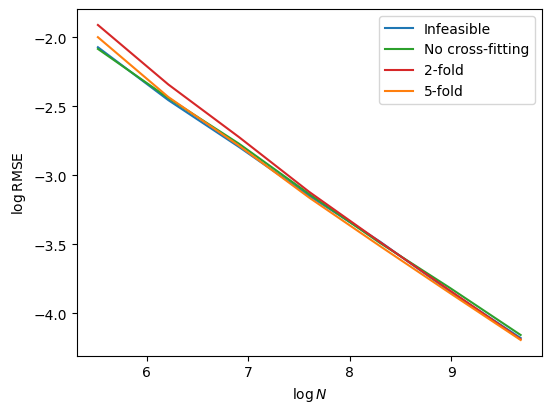

In [7]:
# Convergence rates
rmse = np.empty((len(sample_sizes), 4))

for i, (N, results) in enumerate(results_dict.items()):
    ate_estimates = results[0]
    rmse[i] = np.sqrt(np.mean((ate_estimates-theta_0)**2, axis=0))

plt.figure(figsize=(6, 4.5))
for k in range(4):
    plt.plot(np.log(sample_sizes), np.log(rmse[:,k]), color=colors[k], label=names[k])
plt.xlabel(r'$\log N$')
plt.ylabel(r'$\log$' + 'RMSE')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_2/Convergence_rates_1.{fmt}', dpi=300, bbox_inches='tight')

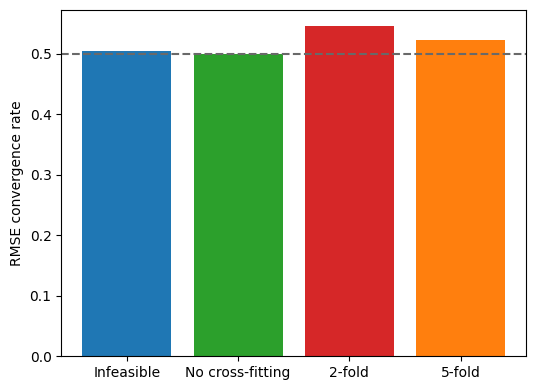

In [8]:
# Convergence rates
slopes = np.polyfit(np.log(sample_sizes), np.log(rmse), 1)[0,:]

plt.figure(figsize=(6, 4.5))
plt.bar(names, -slopes, color=colors)
plt.axhline(y=0.5, color='dimgrey', linestyle='--')
plt.ylabel('RMSE convergence rate')

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_2/Convergence_rates_2.{fmt}', dpi=300, bbox_inches='tight')

In [9]:
-slopes

array([0.50380793, 0.49921812, 0.54502738, 0.52299189])

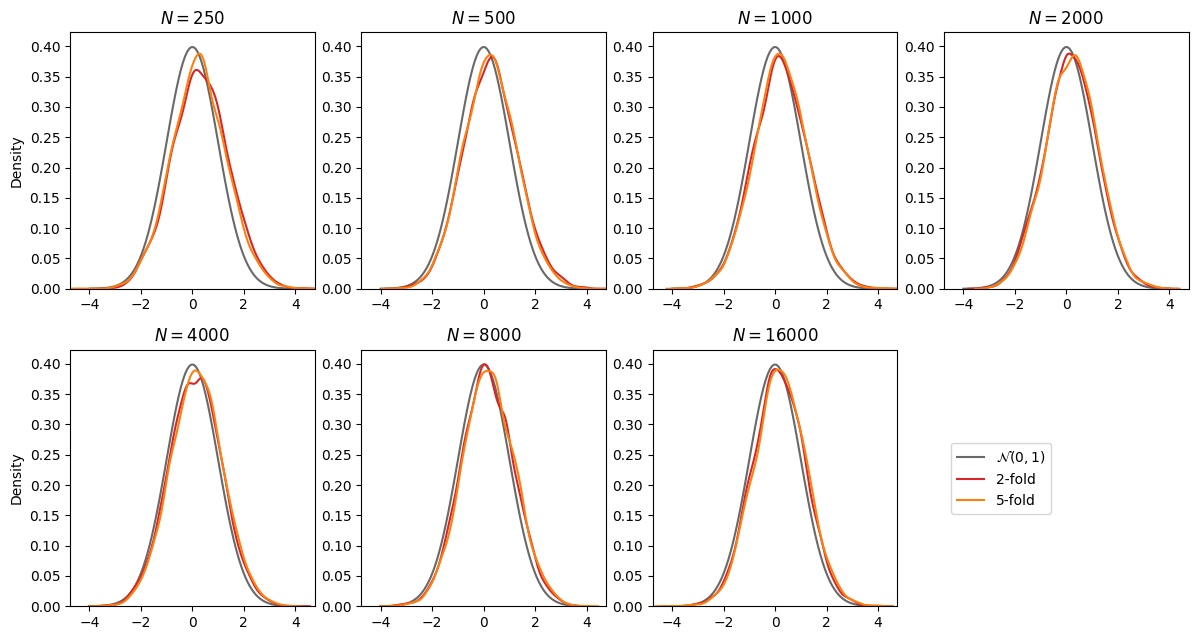

In [10]:
# Asymptotic normality
grid = np.linspace(-4, 4, 100)
pdf_values = norm.pdf(grid)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, (N, results) in enumerate(results_dict.items()):
    ax = axes.flat[i]
    ate_estimates, sigma_estimates, _ = results
    ax.plot(grid, pdf_values, color='dimgrey', label=r'$\mathcal{N}(0,1)$')
    for k in [2, 3]:
        sns.kdeplot(np.sqrt(N)*(ate_estimates[:,k]-theta_0)/sigma_estimates[:,k-2], ax=ax, 
                    color=colors[k], label=names[k])
    ax.set_xlim(left=-4.75, right=4.75)
    ax.set_ylim(bottom=None, top=0.423)
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('')
    if i==0:
        ax.set_xticks([-4, -2, 0, 2, 4])    
    if i==6: 
        handles, labels = ax.get_legend_handles_labels()
  
axes.flat[-1].legend(handles, labels, loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_2/Asymptotic_normality.{fmt}', dpi=300, bbox_inches='tight')

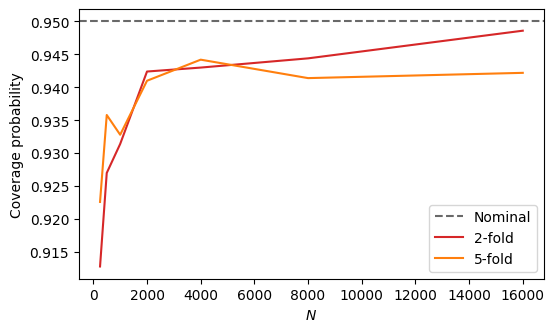

In [12]:
# Coverage probability
cov_prob_list_2, cov_prob_list_5 = [], []

for results in results_dict.values():
    CIs = results[-1]
    cov_prob_2 = np.mean((theta_0>=CIs[:,0]) & (theta_0<=CIs[:,1]))
    cov_prob_5 = np.mean((theta_0>=CIs[:,2]) & (theta_0<=CIs[:,3]))
    cov_prob_list_2.append(cov_prob_2)
    cov_prob_list_5.append(cov_prob_5)

plt.figure(figsize=(6, 3.5))
plt.axhline(y=0.95, color='dimgrey', linestyle='--', label='Nominal')
plt.plot(sample_sizes, cov_prob_list_2, color=colors[2], label=names[2])
plt.plot(sample_sizes, cov_prob_list_5, color=colors[3], label=names[3])

plt.xlabel(r'$N$')
plt.ylabel('Coverage probability')
#plt.yticks([0.930, 0.935, 0.940, 0.945, 0.950])
#plt.ylim(bottom=0.929, top=0.951)
plt.legend(loc='lower right')

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_2/Coverage_probability.{fmt}', dpi=300, bbox_inches='tight')